# Effective Mass Calculations

In this notebook, we compare the perturbation theory calculations with the ones from the vGH Ansatz.

In [2]:
import numpy as np
import autograd.numpy as np
from autograd import grad

import scipy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import time, os, sys, gc

import h5py 

import svgutils.transform as sg 
import sys 

import matplotlib.patches as patches

from scipy.integrate import solve_ivp

import class_energy as energy
import class_equations_of_motion as eom 

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

In [3]:
def quick_pot_scan(params, V_0_arr, folder):
    h5_io_object = h_in.io_hdf5()

    print('\nvGH Calculations:')
    E_arr = np.zeros(len(V_0_arr), dtype=complex)
    for i in range(len(V_0_arr)):
        print('V0 =', V_0_arr[i])
        params["V_0"] = V_0_arr[i]

        eom_object = eom.eom(params=params)
        wavefunc_object = h_wavef.wavefunctions(params=params)
        wfn_manip = h_wavef.wavefunc_operations(params=params)
        ''' 
        Init wavefunction
        '''
        psi_init = wavefunc_object.create_init_wavefunction(params['init_choice'])
        psi_init = wfn_manip.reshape_one_dim(psi_init)
        ''' 
        Imaginary Time Propagation
        '''
        psi, E_evo, epsilon_evo = eom_object.solve_for_fixed_params_imag_time_prop_new(psi_init)
        E_arr[i] = E_evo[-1]

        h5_io_object.save_calculation_run(psi, E_evo, epsilon_evo, params, folder)

    return E_arr

def pert_pot_scan(params, V_0_arr):
    print('\nPerturbative Calculations:')
    E_arr = np.zeros(len(V_0_arr), dtype=complex)
    for i in range(len(V_0_arr)):
        E_min = find_Ep(V_0_arr[i], params["tx"], params["ty"], params["B"], guess_Ep(V_0_arr[i]))
        E_arr[i] = E_min[0]
        print('V0 =', V_0_arr[i], ', E =', E_arr[i])
        
    return E_arr

def get_Ep_from_E_vGH(E_vGH, tx, ty):
    return E_vGH+2*tx+2*ty

def get_E_from_Ep(E_vGH, tx, ty):
    return E_vGH-2*tx-2*ty

def get_E_arr(V_0_range, folder, check_sys, check_sym):
    h5_io_object = h_in.io_hdf5()
    
    E_arr = np.zeros(len(V_0_range), dtype=complex)
    for i in range(len(V_0_range)):
        check_sys_n = check_sys+'_V0_'+str(V_0_range[i])+'_'
        file_list = [f for f in os.listdir(folder) if check_sys_n in f and check_sym in f]
        
        if len(file_list) > 1: 
            break
        for file in file_list:
            file_name = folder+file
            psi, params = h5_io_object.get_psi(file_name)

            energy_object = energy.energy(params=params)
            E, E_T, E_B, E_V = energy_object.calc_energy(psi)
            E_arr[i] = E
    return E_arr

### Define the calculation parameters

In [4]:
params = {"n": 256,
"M": 36,
"Mx": 16,
"Mx_display": 4,
"converge_new_lattice": "no",
"My": 16,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "uniform",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0,0,0,0],
"V_0_pattern": [0,0,0,0],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-10}

x = (2*np.pi/params["n"])*np.arange(params["n"])

''' 
I/O Object
'''
h5_io_object = h_in.io_hdf5()

TODO: make plot for the symmetric case that compares with the perturbation theory - now fixed the coupling points for which we want to compare! Cluster calculations for this are running, don't forget to collect them!! Also, a side benefit is that they provide nice convergence with system size calculations now!!

In [5]:
def var_eff_mass(E_q, E_0, t, M):
    m_0_finite_diff = (t*M**2*(1-np.cos(2*np.pi/M))/np.pi**2)**(-1)
    return ((2*(E_q-E_0)/(2*np.pi/M)**2)**(-1))/m_0_finite_diff

### Ferroelectric order effective mass

In [6]:
tx = 100
ty = 100
t = tx+ty

B = 2.0
Mx = 80
My = 80

V_0_range_fo = np.array([2,4,20,40,60,80,100])

check_sys = 'tx_100.0_ty_100.0'
check_sym = '_B_2.0_Mx_80_My_80_qx_0_qy_0'
folder = 'results/eff_mass/fo/'
E_vGH_fo_B_2_q0 = get_E_arr(V_0_range_fo, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_80_My_80_qx_1_qy_0'
E_vGH_fo_B_2_qx = get_E_arr(V_0_range_fo, folder, check_sys, check_sym)


V_0_range_fo_B_200 = np.array([2,4,20])

check_sys = 'tx_100.0_ty_100.0'
check_sym = '_B_200.0_Mx_80_My_80_qx_0_qy_0'
folder = 'results/eff_mass/fo/'
E_vGH_fo_B_200_q0 = get_E_arr(V_0_range_fo_B_200, folder, check_sys, check_sym)

check_sym = '_B_200.0_Mx_80_My_80_qx_1_qy_0'
E_vGH_fo_B_200_qx = get_E_arr(V_0_range_fo_B_200, folder, check_sys, check_sym)

In [7]:
def func(x, a, b, c):
    return 1+0*x+c*x**2 #a*np.exp(b*x)+c # 
    
mx_fo = var_eff_mass(E_vGH_fo_B_2_qx, E_vGH_fo_B_2_q0, tx, Mx)
print('B = 2; V, mx =', V_0_range_fo, mx_fo)

mx_fo_B_200 = var_eff_mass(E_vGH_fo_B_200_qx, E_vGH_fo_B_200_q0, tx, Mx)
print('B = 200; V, mx =', V_0_range_fo_B_200, mx_fo_B_200)

popt, pcov = scipy.optimize.curve_fit(func, V_0_range_fo, mx_fo.real, p0 = [1, 2, 1]) #bounds=([30,0,-10], [50, 100, 0]))
x_fit = np.linspace(V_0_range_fo[0], V_0_range_fo[-1], 100)
y_fit = func(x_fit, *popt)

print('\nFit params =', popt)

B = 2; V, mx = [  2   4  20  40  60  80 100] [1.00026131-9.01009509e-15j 1.00110194+9.02382594e-15j
 1.02948376+3.09628763e-14j 1.12157874+5.74958358e-15j
 1.28616856-2.62099845e-16j 1.54617687-1.14196437e-14j
 1.94922781-9.26774791e-14j]
B = 200; V, mx = [ 2  4 20] [1.00003368-4.50293896e-15j 1.00013225-6.77326028e-15j
 1.00332125-2.24483705e-15j]

Fit params = [1.00000000e+00 2.00000000e+00 9.08090548e-05]


/mnt/nfs/clustersw/Debian/bullseye/JupyterPython/2.0/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


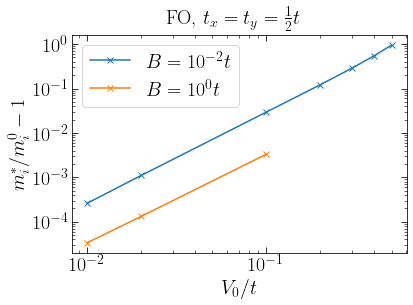

In [8]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'FO, $t_x=t_y=\frac{1}{2}t$', fontsize=font_size)

axs.plot(V_0_range_fo/t, mx_fo.real-1, color='tab:blue', marker='x', linestyle='solid', label=r'$B = 10^{-2} t$')
#axs.plot(x_fit/t, y_fit.real-1, color='tab:blue', linestyle='dashed', label=r'polynomial fit')

axs.plot(V_0_range_fo_B_200/t, mx_fo_B_200.real-1, color='tab:orange', marker='x', linestyle='solid', label=r'$B = 10^{0} t$')


plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_i^*/m_i^0-1$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

#axs.invert_yaxis()
#axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

### Ferro-domain wall effective mass

#### Symmetric Lattice

In [9]:
tx = 100.0
ty = 100.0
t = tx+ty

B = 2.0
Mx_fdv = 8
My_fdv = 256

V_0_range_fdv = np.array([40,60,80,100,120,140])

check_sys = 'tx_100.0_ty_100.0'
check_sym = '_B_2.0_Mx_8_My_256_qx_0_qy_0'
folder = 'results/eff_mass/fdv/'
E_vGH_fdv_B_2_q0 = get_E_arr(V_0_range_fdv, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_8_My_256_qx_0_qy_1'
E_vGH_fdv_B_2_qy = get_E_arr(V_0_range_fdv, folder, check_sys, check_sym)



V_0_range_fdv_x = np.array([100])

check_sym = '_B_2.0_Mx_32_My_128_qx_0_qy_0'
E_vGH_fdv_B_2_q0x = get_E_arr(V_0_range_fdv_x, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_32_My_128_qx_1_qy_0'
E_vGH_fdv_B_2_qx = get_E_arr(V_0_range_fdv_x, folder, check_sys, check_sym)

In [10]:
my_fdv = var_eff_mass(E_vGH_fdv_B_2_qy, E_vGH_fdv_B_2_q0, ty, My_fdv)
mx_fdv = var_eff_mass(E_vGH_fdv_B_2_qx, E_vGH_fdv_B_2_q0x, tx, 32)

print('my =', my_fdv)
print('mx =', mx_fdv)

my = [ 8.83724151+4.45500380e-11j 11.75131569+7.89254680e-11j
 14.00723719+1.06157665e-10j 15.96870625-2.15776103e-11j
 17.86564878+3.15117454e-11j 19.93322696-2.17182533e-10j]
mx = [8905158.8713718-0.00235072j]


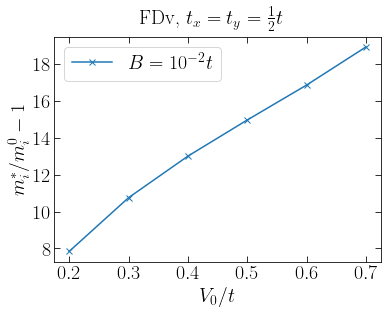

In [11]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'FDv, $t_x=t_y=\frac{1}{2}t$', fontsize=font_size)

axs.plot(V_0_range_fdv/t, my_fdv.real-1, color='tab:blue', marker='x', linestyle='solid', label=r'$B = 10^{-2} t$')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_i^*/m_i^0-1$', fontsize=font_size)

plt.xticks(V_0_range_fdv/t, fontsize=font_size)
plt.yticks(fontsize=font_size)

#axs.set_xscale('log', base=10)
#axs.set_yscale('log', base=10)

#axs.invert_yaxis()
#axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

TODO: calculate the effective mass here for the FDW perpendicular direction - also verify what the FDW$_y$ states really are, I suspect they are small polaron states. Here is a mental note - the FDv states don't make sense as here they correspond to SP states, i.e. they converged to the higher energy branch.

### Small polaron effective mass

In [12]:
tx = 100
ty = 100
t = tx+ty

B = 2.0
Mx_sp = 32
My_sp = 32

V_0_range_sp = np.array([150,170,190,210,250,300,350,500,700,900,1000,1100,1200,1300,1400]) #,1500,1600])

check_sys = 'tx_100.0_ty_100.0'
check_sym = '_B_2.0_Mx_32_My_32_qx_0_qy_0'
folder = 'results/eff_mass/sp/'
E_vGH_sp_B_2_q0 = get_E_arr(V_0_range_sp, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_32_My_32_qx_0_qy_1'
E_vGH_sp_B_2_qy = get_E_arr(V_0_range_sp, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_32_My_32_qx_1_qy_0'
E_vGH_sp_B_2_qx = get_E_arr(V_0_range_sp, folder, check_sys, check_sym)

In [13]:
mx_sp = var_eff_mass(E_vGH_sp_B_2_qx, E_vGH_sp_B_2_q0, tx, Mx_sp)
my_sp = var_eff_mass(E_vGH_sp_B_2_qy, E_vGH_sp_B_2_q0, ty, My_sp)

print('mx =', mx_sp)
print('my =', my_sp)

mx = [2.66043406e+04+1.18450569e-08j 4.66356776e+04-1.16657864e-07j
 7.84379751e+04+7.20475446e-08j 1.27685843e+05-1.08039650e-07j
 3.13612097e+05+1.88008936e-05j 8.65483655e+05+2.00730373e-04j
 2.18302154e+06-3.12997133e-04j 2.42281640e+07-1.23238137e-02j
 3.48354139e+08-2.11023198e+01j 3.41996076e+09+1.95563091e+03j
 9.66901951e+09+2.30141492e+04j 2.64085095e+10-3.04536478e+05j
 6.60212738e+10-6.98551903e+04j 1.62513905e+11-6.00368421e+06j
 3.84123766e+11+5.97820724e+07j]
my = [2.66043323e+04-5.13769130e-08j 4.66356773e+04-3.57928708e-08j
 7.84380310e+04-4.18060477e-07j 1.27685714e+05-5.40129665e-07j
 3.13612178e+05+1.18421418e-05j 8.65485871e+05-1.85735372e-06j
 2.18282841e+06-1.47520424e-04j 2.42279904e+07+2.92117311e-02j
 3.48354139e+08-1.68723707e+01j 3.42134536e+09+4.52239728e+03j
 9.69119616e+09+9.29557342e+03j 2.62444815e+10+6.05334092e+03j
 6.60212738e+10-6.31822885e+05j 1.62513905e+11-5.18546038e+06j
 4.22536140e+11+7.28663712e+07j]


In [14]:
x_exp_guide_sp_sy = np.linspace(0.75,7,100)
y_exp_guide_sp_sy = 2*10**6*np.exp(1.75*x_exp_guide_sp_sy) 

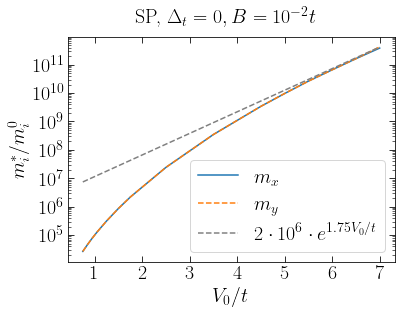

In [15]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'SP, $\Delta_t = 0, B = 10^{-2} t$', fontsize=font_size)

axs.plot(V_0_range_sp/t, mx_sp.real, color='tab:blue', linestyle='solid', label=r'$m_x$')
axs.plot(V_0_range_sp/t, my_sp.real, color='tab:orange', linestyle='dashed', label=r'$m_y$')

axs.plot(x_exp_guide_sp_sy, y_exp_guide_sp_sy, color='grey', linestyle='dashed', label=r'$2\cdot 10^{6}\cdot e^{1.75V_0/t}$')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_i^*/m_i^0$', fontsize=font_size)

plt.xticks(fontsize=font_size) #V_0_range_sp/t, 
plt.yticks(fontsize=font_size)

#axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=4)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True, labelsize=font_size)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True, labelsize=font_size)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

### Effective mass overview in all regimes

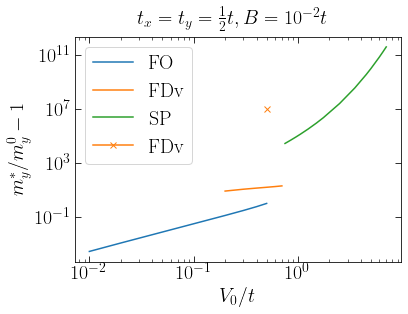

In [16]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'$t_x=t_y=\frac{1}{2}t, B = 10^{-2} t$', fontsize=font_size)

axs.plot(V_0_range_fo/t, mx_fo.real-1, color='tab:blue', linestyle='solid', label=r'FO')
axs.plot(V_0_range_fdv/t, my_fdv.real-1, color='tab:orange', linestyle='solid', label=r'FDv')
axs.plot(V_0_range_sp/t, mx_sp.real-1, color='tab:green', linestyle='solid', label=r'SP')


axs.plot(V_0_range_fdv_x/t, mx_fdv.real-1, marker='x', color='tab:orange', linestyle='solid', label=r'FDv')


plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_y^*/m_y^0-1$', fontsize=font_size)

plt.xticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

#axs.invert_yaxis()
#axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True, labelsize=font_size)
plt.tick_params(axis='y', direction='in', length=6, right=True, labelsize=font_size)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True, labelsize=font_size)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True, labelsize=font_size)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.savefig('results/eff_mass/eff_mass_sym_case_B_2.0.pdf', bbox_inches='tight', dpi=50)

# Effective Mass Calculations for the asymmetric lattice
## Ferro-Order

In [17]:
tx = 150
ty = 50
t = tx+ty

B = 2.0
Mx = 80
My = 80

V_0_range_fo_as = np.array([2,4,20,50])

check_sys = 'tx_150.0_ty_50.0'
check_sym = '_B_2.0_Mx_80_My_80_qx_0_qy_0'
folder = 'results/eff_mass/fo/'
E_vGH_fo_as_B_2_q0 = get_E_arr(V_0_range_fo_as, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_80_My_80_qx_1_qy_0'
E_vGH_fo_as_B_2_qx = get_E_arr(V_0_range_fo_as, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_80_My_80_qx_0_qy_1'
E_vGH_fo_as_B_2_qy = get_E_arr(V_0_range_fo_as, folder, check_sys, check_sym)

In [18]:
import scipy 

def func(x, a, b, c):
    return 1+0*x+c*x**2 #a*np.exp(b*x)+c # 
    
mx_fo_as = var_eff_mass(E_vGH_fo_as_B_2_qx, E_vGH_fo_as_B_2_q0, tx, Mx)
print('mx =', mx_fo_as)

my_fo_as = var_eff_mass(E_vGH_fo_as_B_2_qy, E_vGH_fo_as_B_2_q0, ty, My)
print('my =', my_fo_as)

popt, pcov = scipy.optimize.curve_fit(func, V_0_range_fo_as, mx_fo_as.real, p0 = [1, 2, 1]) #bounds=([30,0,-10], [50, 100, 0]))
x_fit_as = np.linspace(V_0_range_fo_as[0], V_0_range_fo_as[-1], 100)
y_fit_as = func(x_fit_as, *popt)

print('\nFit params =', popt)

mx = [1.00031841-4.50693934e-15j 1.00133164-1.58002282e-14j
 1.03523986+2.65205328e-14j 1.23412407+6.58597677e-15j]
my = [1.00044992-3.60436422e-14j 1.001883  +1.35557019e-14j
 1.05014679-3.95597231e-14j 1.35614178+7.08469151e-14j]

Fit params = [1.00000000e+00 2.00000000e+00 9.35106494e-05]


/mnt/nfs/clustersw/Debian/bullseye/JupyterPython/2.0/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


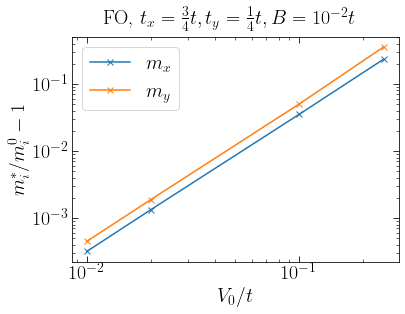

In [19]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'FO, $t_x=\frac{3}{4}t, t_y=\frac{1}{4}t, B = 10^{-2} t$', fontsize=font_size)

axs.plot(V_0_range_fo_as/t, mx_fo_as.real-1, color='tab:blue', marker='x', linestyle='solid', label=r'$m_x$')
axs.plot(V_0_range_fo_as/t, my_fo_as.real-1, color='tab:orange', marker='x', linestyle='solid', label=r'$m_y$')
#axs.plot(x_fit_as/t, y_fit_as.real-1, color='tab:blue', linestyle='dashed', label=r'polynomial fit')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_i^*/m_i^0-1$', fontsize=font_size)

plt.xticks(fontsize=font_size)

'''
Scale
'''
axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.legend(fontsize=font_size, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True, labelsize=font_size)
plt.tick_params(axis='y', direction='in', length=6, right=True, labelsize=font_size)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

## Ferro-Domain Wall

A remark about the FDv states - they don't make sense as here they correspond to SP states, i.e. they converged to the higher energy branch somehow. Though that's not too unexpected since we are in the regime where the FDh is the definite ground state.

In [21]:
tx = 150.0
ty = 50.0
t = tx+ty

B = 2.0
Mx_fdv = 4
My_fdv = 128

V_0_range_fdv_as = np.array([50,100,150,200,250])

'''
FDv - these results don't make sense, see explanation in the markdown text
'''
check_sys = 'tx_150.0_ty_50.0'
check_sym = '_B_2.0_Mx_4_My_128_qx_0_qy_0'
folder = 'results/eff_mass/fdv/'
E_vGH_fdv_as_B_2_q0 = get_E_arr(V_0_range_fdv_as, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_4_My_128_qx_0_qy_1'
E_vGH_fdv_as_B_2_qy = get_E_arr(V_0_range_fdv_as, folder, check_sys, check_sym)


''' 
Fdh
'''
check_sys = 'tx_150.0_ty_50.0'
check_sym = '_B_2.0_Mx_128_My_4_qx_0_qy_0'
folder = 'results/eff_mass/fdh/'
E_vGH_fdh_as_B_2_q0 = get_E_arr(V_0_range_fdv_as, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_128_My_32_qx_0_qy_0'
E_vGH_fdh_as_B_2_q0_y = get_E_arr(V_0_range_fdv_as, folder, check_sys, check_sym)


check_sym = '_B_2.0_Mx_128_My_4_qx_1_qy_0'
E_vGH_fdh_as_B_2_qx = get_E_arr(V_0_range_fdv_as, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_128_My_32_qx_0_qy_1'
E_vGH_fdh_as_B_2_qy = get_E_arr(V_0_range_fdv_as, folder, check_sys, check_sym)

In [22]:
my_fdv_as = var_eff_mass(E_vGH_fdv_as_B_2_qy, E_vGH_fdv_as_B_2_q0, 50, 128)

mx_fdh_as = var_eff_mass(E_vGH_fdh_as_B_2_qx, E_vGH_fdh_as_B_2_q0, 150, 128)
my_fdh_as = var_eff_mass(E_vGH_fdh_as_B_2_qy, E_vGH_fdh_as_B_2_q0_y, 50, 32)

print('FDv, my =', my_fdv_as)

print('FDh, mx =', mx_fdh_as)
print('FDh, my =', my_fdh_as)

FDv, my = [1.05581123e+01+3.94535357e-12j 4.87519910e+03+3.07078974e-08j
 2.29187684e+04-1.06499051e-06j 1.00902453e+05-3.14907043e-05j
 3.14392608e+05+4.63433116e-04j]
FDh, mx = [10.53474265-2.55620827e-12j 16.34278721-1.08420315e-11j
 20.21898502-9.27958554e-12j 23.79362249-3.06419729e-12j
 28.75540677+1.03840897e-11j]
FDh, my = [2.93926778e+05-5.96063536e-06j 9.08345373e+07+5.02519190e-01j
 9.23879201e+08-8.82590512e+00j 1.92214786e+09+1.14172046e+02j
 1.64876072e+09+4.01595943e+01j]


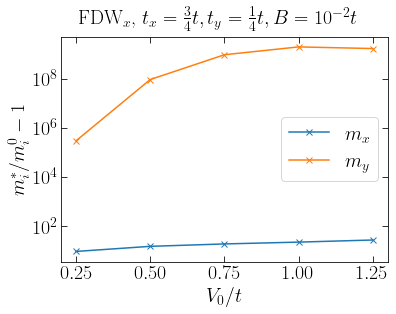

In [23]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'FDW$_x$, $t_x=\frac{3}{4}t, t_y=\frac{1}{4}t, B=10^{-2}t$', fontsize=font_size)

#axs.plot(V_0_range_fdv_as/t, my_fdv_as.real-1, color='tab:blue', marker='x', linestyle='solid', label=r'$m_y (FDW_y)$')
axs.plot(V_0_range_fdv_as/t, mx_fdh_as.real-1, color='tab:blue', marker='x', linestyle='solid', label=r'$m_x$')
axs.plot(V_0_range_fdv_as/t, my_fdh_as.real-1, color='tab:orange', marker='x', linestyle='solid', label=r'$m_y$')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_i^*/m_i^0-1$', fontsize=font_size)

plt.xticks(V_0_range_fdv_as/t, fontsize=font_size)
plt.yticks(fontsize=font_size)

'''
Scale
'''
#axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.legend(fontsize=font_size, loc=5)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

## Small Polaron

We show that the small polaron effective mass is the same in the symmetric and asymmetric case (i.e. $\Delta =0\,\&\,0.5$). Furthermore, we compare the effective mass to an exponential guide to the eye.

In [24]:
tx = 150.0
ty = 50.0
t = tx+ty

B = 2.0
Mx_fdv = 32
My_fdv = 32

V_0_range_sp_as = np.array([200,350,500,700,900,1000,1100,1200,1300,1400]) #,1500])

''' 
SP
'''
check_sys = 'tx_150.0_ty_50.0'
check_sym = '_B_2.0_Mx_32_My_32_qx_0_qy_0'
folder = 'results/eff_mass/sp/'
E_vGH_sp_as_B_2_q0 = get_E_arr(V_0_range_sp_as, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_32_My_32_qx_1_qy_0'
E_vGH_sp_as_B_2_qx = get_E_arr(V_0_range_sp_as, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_32_My_32_qx_0_qy_1'
E_vGH_sp_as_B_2_qy = get_E_arr(V_0_range_sp_as, folder, check_sys, check_sym)

In [25]:
mx_sp_as = var_eff_mass(E_vGH_sp_as_B_2_qx, E_vGH_sp_as_B_2_q0, 150, 32)
my_sp_as = var_eff_mass(E_vGH_sp_as_B_2_qy, E_vGH_sp_as_B_2_q0, 50, 32)

print('SP, mx =', mx_sp_as)
print('SP, my =', my_sp_as)

SP, mx = [9.97912765e+04-7.09559098e-08j 2.18118675e+06+3.66620253e-04j
 2.42174138e+07-8.97947218e-02j 3.48368499e+08+1.03506303e+01j
 3.42226905e+09+1.65700048e+03j 9.68379265e+09+1.00039782e+04j
 2.59755831e+10-2.17388235e+05j 6.67162346e+10+1.73332115e+04j
 1.66790586e+11+7.61382932e+06j 3.72826016e+11+1.29453271e+07j]
SP, my = [1.00840460e+05+8.32056381e-07j 2.18403651e+06+4.09786087e-04j
 2.41757989e+07-2.07714309e-01j 3.48368499e+08+4.30928410e+01j
 3.42134536e+09+4.72555300e+03j 9.69119616e+09-5.42872984e+03j
 2.57643995e+10-3.93499371e+05j 7.04226921e+10-9.44956312e+05j
 1.62513904e+11+1.16649118e+07j 3.52113446e+11-7.13563493e+07j]


In [26]:
x_exp_guide_sp_as = np.linspace(1,7,100)
y_exp_guide_sp_as = 2*10**6*np.exp(1.75*x_exp_guide_sp_as) 

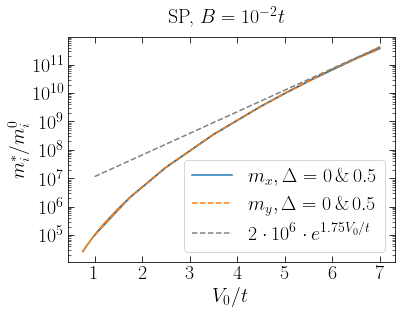

In [27]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'SP, $B=10^{-2}t$', fontsize=font_size)

axs.plot(V_0_range_sp/t, mx_sp.real, color='tab:blue', linestyle='solid')
axs.plot(V_0_range_sp/t, my_sp.real, color='tab:orange', linestyle='solid')

axs.plot(V_0_range_sp_as/t, mx_sp_as.real, color='tab:blue', linestyle='solid', label=r'$m_x, \Delta = 0\,\&\,0.5$')
axs.plot(V_0_range_sp_as/t, my_sp_as.real, color='tab:orange', linestyle='dashed', label=r'$m_y, \Delta = 0\,\&\,0.5$')

#axs.plot(V_0_range_sp/t, mx_sp.real, color='tab:orange', linestyle='solid', label=r'$m_y$')

axs.plot(x_exp_guide_sp_as, y_exp_guide_sp_as, color='grey', linestyle='dashed', label=r'$2\cdot 10^{6}\cdot e^{1.75V_0/t}$')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_i^*/m_i^0$', fontsize=font_size)

plt.xticks(fontsize=font_size) #V_0_range_fdv_as/t,
plt.yticks(fontsize=font_size)

#axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.legend(fontsize=font_size, loc=4)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

## Overview figure of effective masses in the asymmetric lattice
Note: the arrangement of this figure was inspired by the post on https://towardsdatascience.com/plot-organization-in-matplotlib-your-one-stop-guide-if-you-are-reading-this-it-is-probably-f79c2dcbc801.

TODO: include error bars wherever applicable!

In [28]:
V_0_range_fo

array([  2,   4,  20,  40,  60,  80, 100])

In [29]:
x_quadr_eye_guide = np.linspace(2,100,100)
y_quadr_eye_guide = 1e-2*x_quadr_eye_guide**2/t

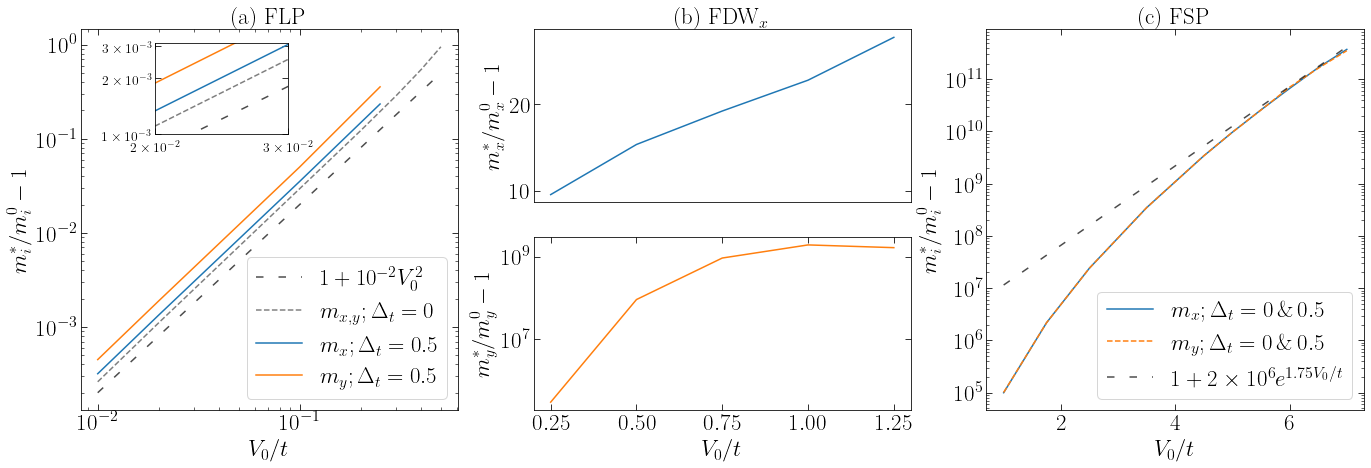

In [34]:
A = 4
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 23

fig = plt.figure(figsize=(23, 7))
gs = GridSpec(nrows=2, ncols=3)

'''
FO
'''
ax0 = fig.add_subplot(gs[:, 0])
ax0.set_title(r'(a) FLP', fontsize=font_size)

ax0.plot(x_quadr_eye_guide/t, y_quadr_eye_guide, color='black', linestyle='dashed', alpha=0.7, dashes=(5,10), label=r'$1+10^{-2} V_0^2$')

ax0.plot(V_0_range_fo/t, mx_fo.real-1, color='grey', linestyle='dashed', label=r'$m_{x,y}; \Delta_t = 0$')

ax0.plot(V_0_range_fo_as/t, mx_fo_as.real-1, color='tab:blue', linestyle='solid', label=r'$m_x; \Delta_t = 0.5$')
ax0.plot(V_0_range_fo_as/t, my_fo_as.real-1, color='tab:orange', linestyle='solid', label=r'$m_y; \Delta_t = 0.5$')

ax0.set_xscale('log', base=10)
ax0.set_yscale('log', base=10)

ax0.set_xscale('log', base=10)
ax0.set_yscale('log', base=10)

ax0.legend(fontsize=0.99*font_size, loc=4)

ax0.set_xlabel(r'$V_0/t$', fontsize=font_size)
ax0.set_ylabel(r'$m_i^*/m_i^0-1$', fontsize=font_size)

ax0.tick_params(axis='x', direction='in', length=6, top=True, labelsize=font_size)
ax0.tick_params(axis='y', direction='in', length=6, right=True, labelsize=font_size)
ax0.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
ax0.tick_params(axis='y', which='minor', direction='in', length=3, right=True)


ax01 = fig.add_axes([0.17, 0.673, 0.08, 0.18])

ax01.plot(x_quadr_eye_guide/t, y_quadr_eye_guide, color='black', linestyle='dashed', alpha=0.7, dashes=(5,10), label=r'$10^{-2} V_0^2$')
ax01.plot(V_0_range_fo/t, mx_fo.real-1, color='grey', linestyle='dashed', label=r'$m_{x,y}; \Delta_t = 0$')

ax01.plot(V_0_range_fo_as/t, mx_fo_as.real-1, color='tab:blue', linestyle='solid', label=r'$m_x; \Delta_t = 0.5$')
ax01.plot(V_0_range_fo_as/t, my_fo_as.real-1, color='tab:orange', linestyle='solid', label=r'$m_y; \Delta_t = 0.5$')

ax01.set_xscale('log', base=10)
ax01.set_yscale('log', base=10)

ax01.set_xlim(2e-2,3e-2)
ax01.set_ylim(1e-3,3.1e-3)

ax01.set_xticks([2e-2,3e-2],[r'$2\times 10^{-2}$',r'$3\times 10^{-2}$'])
ax01.set_yticks([1e-3,2e-3,3e-3],[r'$1\times 10^{-3}$',r'$2\times 10^{-3}$',r'$3\times 10^{-3}$'])

ax01.tick_params(axis='x', direction='in', length=6, top=True, pad=6, labelsize=0.6*font_size)
ax01.tick_params(axis='y', direction='in', length=6, right=True, labelsize=0.6*font_size)
ax01.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
ax01.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

#ax01.set_xlabel(r'$V_0/t$', fontsize=font_size)
#ax01.set_ylabel(r'$m_i^*/m_i^0-1$', fontsize=font_size)



'''
FDh m_x
'''
ax1 = fig.add_subplot(gs[0, 1])
ax1.set_title(r'(b) FDW$_x$', fontsize=font_size)

ax1.plot(V_0_range_fdv_as/t, mx_fdh_as.real-1, color='tab:blue', linestyle='solid', label=r'$m_x$ (FDW$_x$)')

#ax1.plot(V_0_range_fdv/t, my_fdv.real-1, color='tab:orange', linestyle='solid', label=r'FDv')

ax1.set_xticks([],[])

ax1.set_ylabel(r'$m_x^*/m_x^0-1$', fontsize=font_size)

ax1.tick_params(axis='x', direction='in', length=6, top=True, labelsize=font_size)
ax1.tick_params(axis='y', direction='in', length=6, right=True, labelsize=font_size)
ax1.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
ax1.tick_params(axis='y', which='minor', direction='in', length=3, right=True, labelsize=font_size)


'''
FDh m_y
'''
ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(V_0_range_fdv_as/t, my_fdh_as.real-1, color='tab:orange', linestyle='solid', label=r'$m_y$ (FDW$_x$)')

ax2.set_yscale('log', base=10)

ax2.set_xlabel(r'$V_0/t$', fontsize=font_size)
ax2.set_ylabel(r'$m_y^*/m_y^0-1$', fontsize=font_size)

ax2.tick_params(axis='x', direction='in', length=6, top=True, labelsize=font_size)
ax2.tick_params(axis='y', direction='in', length=6, right=True, labelsize=font_size)
ax2.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
ax2.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

'''
SP
'''
ax3 = fig.add_subplot(gs[:, 2])
ax3.set_title(r'(c) FSP', fontsize=font_size)

ax3.plot(V_0_range_sp_as/t, mx_sp_as.real-1, color='tab:blue', linestyle='solid', label=r'$m_x; \Delta_t = 0\, \&\, 0.5$')
ax3.plot(V_0_range_sp_as/t, my_sp_as.real-1, color='tab:orange', linestyle='dashed', label=r'$m_y; \Delta_t = 0\, \&\, 0.5$')

ax3.plot(x_exp_guide_sp_as, y_exp_guide_sp_as, color='black', linestyle='dashed', dashes=(5,10), alpha=0.7, label=r'$1+2\times 10^{6} e^{1.75V_0/t}$')

ax3.set_yscale('log', base=10)

ax3.set_xlabel(r'$V_0/t$', fontsize=font_size)
ax3.set_ylabel(r'$m_i^*/m_i^0-1$', fontsize=font_size)

ax3.legend(fontsize=font_size)

ax3.tick_params(axis='x', direction='in', length=6, top=True, labelsize=font_size)
ax3.tick_params(axis='y', direction='in', length=6, right=True, labelsize=font_size)
ax3.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
ax3.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.savefig('results/eff_mass/eff_mass_sum_B_2.0.pdf', bbox_inches='tight', dpi=50)